In [16]:
import pandas as pd
import numpy as np
import torch as torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
import torch.nn as nn
from PIL import Image
from skorch import NeuralNet, callbacks, NeuralNetClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
import pickle


In [2]:
# Class to read the dataset from a CSV file
class Dataset(torch.utils.data.Dataset):      
    def __init__(self, csv_file):
        self.dataset_frame = pd.read_csv(csv_file)
        self.transform = transforms.Compose([
#             transforms.Grayscale(num_output_channels=1),
            transforms.Resize((32,32)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ])
    
    def __len__(self):
        return len(self.dataset_frame)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        file = self.dataset_frame.iloc[index,0]
        X = Image.open(file)
        X = self.transform(X)
        y = self.dataset_frame.iloc[index,1]

        return X, y

# Calling the class to read the path of the images from the CSV file.    
ds = Dataset("./csv/train.csv")
dt = Dataset("./csv/test.csv")

# Loading the images
train_dl = DataLoader(ds, 3000, shuffle=True)
test_dl = DataLoader(dt, 150, shuffle=False)

# Train and validation set preparation
X, y = next(iter(train_dl))

# X_test and y_test array preparation
X_test, y_test = next(iter(test_dl))

print("Data is successfully loaded to the memory!")

Data is successfully loaded to the memory!


In [8]:
# Network engine to train the data.
class Network(nn.Module):
    def __init__(self, num_channels=32, num_labels=3):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    
    def forward(self,x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
# Skorch NNClassifier.
net = NeuralNetClassifier(
    module=Network,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    optimizer__momentum=0.9,
    lr=0.01,
    callbacks=[
        ('tr_acc', callbacks.EpochScoring(
            'accuracy',
            lower_is_better=False,
            on_train=True,
            name='train_acc',
        )),
    ],
#     iterator_valid__batch_size=4,
#     iterator_train__batch_size=4,
    max_epochs= 10
)

# Training the data
net.fit(X,y)

# Creating a pipline to store the model.
model = Pipeline([
    ('net', net),
])

# Storing the model.
with open('some-file.pkl', 'wb') as f:
    pickle.dump(model, f)

  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.3508        1.0992       0.3600        1.0843  1.1231
      2       0.4363        1.0754       0.4350        1.0519  1.1024
      3       0.4367        1.0394       0.6050        0.9857  1.0754
      4       0.6454        0.9220       0.7667        0.7296  1.0703
      5       0.7588        0.6273       0.7967        0.4976  1.0558
      6       0.8087        0.4849       0.8417        0.4240  1.0849
      7       0.8467        0.4041       0.8433        0.3870  1.0979
      8       0.8729        0.3488       0.8617        0.3463  1.0969
      9       0.8821        0.3190       0.8967        0.3216  1.0849
     10       0.9021        0.2697       0.9100        0.2714  1.0754


E:\ANACONDA\lib\site-packages\torch\serialization.py:359: UserWarning: Couldn't retrieve source code for container of type Network. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


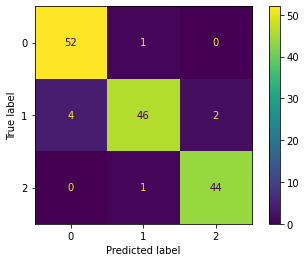

              precision    recall  f1-score   support

           0       0.93      0.98      0.95        53
           1       0.96      0.88      0.92        52
           2       0.96      0.98      0.97        45

    accuracy                           0.95       150
   macro avg       0.95      0.95      0.95       150
weighted avg       0.95      0.95      0.95       150



In [19]:
# Prediction using the trained model
y_pred = net.predict(X_test)

# Creating the confusion matrix using
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(net, X_test, y_test)  
plt.show()

# Classification Report usint pred and test results
print(classification_report(y_test, y_pred))

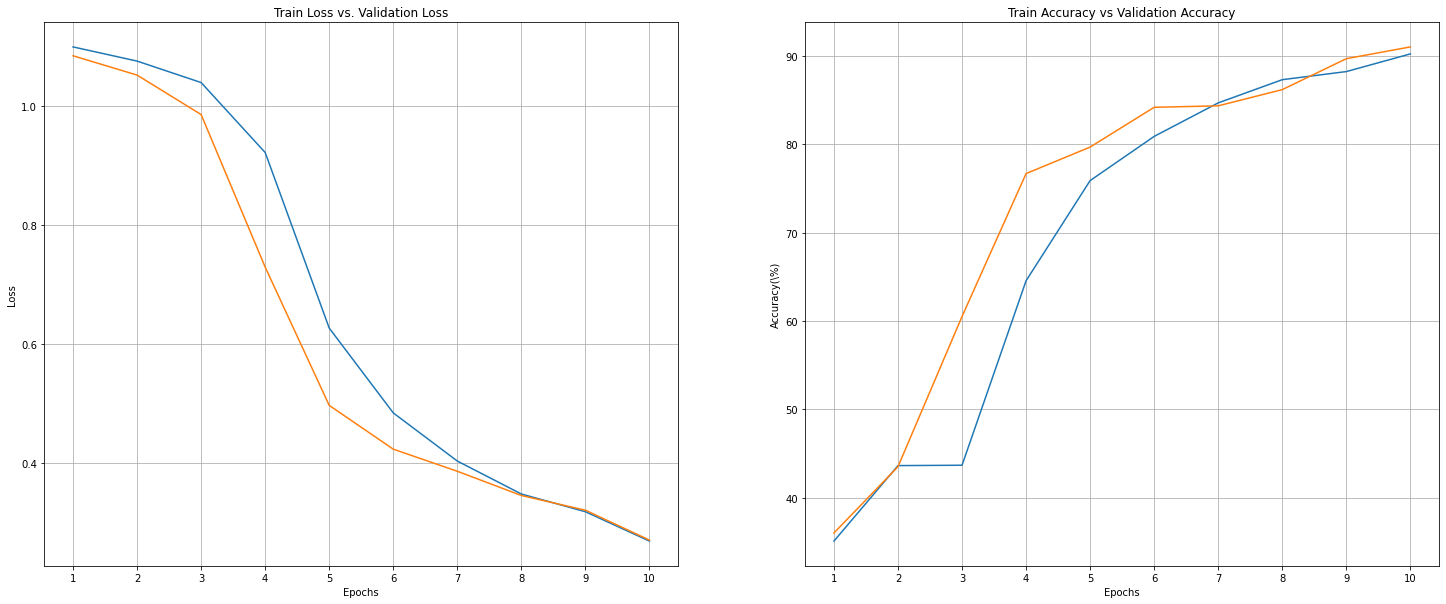

In [20]:
# Plotting the history of the train and the accuracy.

fig, axs = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(25)

train_losses = np.asarray(net.history[:, ('train_loss')])
valid_losses = np.asarray(net.history[:, ('valid_loss')])
axs[0].set_title('Train Loss vs. Validation Loss')
axs[0].set(xlabel='Epochs', ylabel='Loss')
plt.setp(axs[0], xticks=np.arange(30), xticklabels=np.arange(1,31),
        yticks=np.arange(10,step=0.2))
axs[0].plot(train_losses)
axs[0].plot(valid_losses)
axs[0].grid()

train_acc = np.asarray(net.history[:, ('train_acc')]) * 100
valid_acc = np.asarray(net.history[:, ('valid_acc')]) * 100
axs[1].set_title('Train Accuracy vs Validation Accuracy')
axs[1].set(xlabel='Epochs', ylabel='Accuracy(\%)')
plt.setp(axs[1], xticks=np.arange(30), xticklabels=np.arange(1,31),
        yticks=np.arange(110,step=10))
axs[1].plot(train_acc)
axs[1].plot(valid_acc)
axs[1].grid()
plt.show()
